# Cloud Simulations for DIAL / IPDA

This is a continuation of the work in "sim_high_flux.ipynb" to simulate a cloud measurement and DIAL calculation.
This will evaluate the error when using the Mueller correction on the cloud base bin for DIAL and/or IPDA.

$$P(\lambda, R) = P_0\frac{c\Delta t}{2}\frac{A}{R^2}\beta(\lambda, R)\exp\left(-2\tau\left[\lambda, R\right]\right)\eta G+P_B$$
$$\tau(\lambda, R)=\int_{0}^{R}\alpha(\lambda, R')dR'$$
$$\alpha(\lambda, R)=\sigma_{abs}(\lambda, R)n(R)$$
$$\Delta\tau\triangleq\tau(\lambda_1, R)-\tau(\lambda_2, R)=n(R)(\sigma_{abs}(\lambda_1, R)-\sigma_{abs}(\lambda_2, R)=n(R)\Delta\sigma(\lambda_1,\lambda_2, R)$$
$$\frac{P(\lambda_1, R)}{P(\lambda_2, R)}=\frac{\beta(\lambda_1, R)}{\beta(\lambda_2, R)}\exp\left(-2\Delta\tau[\lambda_1, \lambda_2, R]\right)$$
if $P_B=0$. 
$$\Delta\tau(\lambda_1, \lambda_2, R)=-\frac{1}{2}\left(\ln\left[\frac{P_1(R)}{P_2(R)}\right]+\ln\left[\frac{\beta_2}{\beta_1}\right]\right)$$
If we select wavelengths close enough to each other such that the ratio $\frac{\beta_2}{\beta_1}$ is unity (even in a cloud), then
$$\Delta\tau(\lambda_1, \lambda_2, R)=-\frac{1}{2}\ln\left(\frac{P_1[R]}{P_2[R]}\right)$$
$$n(R)=\frac{1}{2\Delta\sigma(\lambda_1,\lambda_2,R)}\ln\left(\frac{P_1[R]}{P_2[R]}\right)$$

I think below cloud, an optical depth $\tau=1$ is reasonable. Within the cloud, an optical depth of $\tau=15$ is reasonable.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

eps = sys.float_info.epsilon

In [4]:
def gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S, beta_aer, alpha_mol, beta_mol, dR, N_L, A, eta, G, N_B, dt):
    R = alt - plat_height  # [m] Remove platform height to convert to range
    
    cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))
    cloud = np.ones(len(alt))
    cloud *= cloud_sig
    
    beta_aer *= cloud  # [m-1 sr-1]
    alpha_aer = S * beta_aer
        
    trans = np.exp(-np.cumsum((alpha_mol+alpha_aer)*dR))
    N_com = N_L*(beta_mol + beta_aer)*dR*A/R**2*trans**2*eta*G + N_B
    N_com[0] = 0

    rho_func = N_com / dt  # [Hz]
    photon_rate = rho_func  # [Hz]
   
    return photon_rate, N_com, cloud

In [205]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

L = 9e-3  # [K/km] Temperature lapse rate for Denver
P_0 = 840  # [mbar] Typical absolute pressure for Denver
T_0 = 294.3  # [K] Typical 70 F temperature for Denver
lamb = 828e-9  # [m] laser wavelength

D = 8  # [in] outer diameter of telescope
d = 1.8  # [in] inner diameter of telescope

dt_TCSPC = 250e-12  # [s] native resolution of TCSPC

# Laser specs
P_L = 35e-3  # [W] average laser power
dt_L = 700e-12  # [s] laser pulse FWHM
f_L = 14.7e3  # [Hz] rep rate

# Receiver specs (at 532 nm)
R_tele = 0.95  # Telescope reflectance
R_M = 0.99  # Folding mirror reflectance
T_L = 0.9  # Standard lens transmittance
mu_F = 0.994  # [m-1] Fiber transmission coefficient
L_F = 2  # [m] Fiber length
T_F = mu_F * L_F  # Fiber transmittance
T_FC = T_L  # Fiber coupler transmittance
T_BS_LG = 0.05  # Beam-splitter low-gain transmittance
T_BS_HG = 0.95  # Beam-splitter high-gain transmittance
T_SBF = 0.9  # Solar background filter transmittance
eta_QE = 0.5  # Detector quantum efficiency
loss = 10  # Unaccounted loss term
tD = 20e-9  # [s] SPAD deadtime

dalt = c * dt_TCSPC / 2  # [m]
alt = np.arange(eps, 1.25e3, dalt)  # [m] target range

In [206]:
# Calculate Temperature and Pressure
T = T_0 - L/1000*alt  # [K]

C_g = g_0*M_air/R_0/L
P = P_0 * (T/T_0)**C_g  # [mbar]

# Scattering coefficients
beta_mol = 2.938e-32 * P/T * lamb**(-4.0117)  # [m-1 sr-1]
alpha_mol = 8*np.pi/3 * beta_mol  # [m-1]

# Telescope parameters
A = np.pi/4*(D**2-d**2)  # [in^2]
A *= (0.0254**2)  # [m^2] Area

# Geometric overlap
# G = 1  # assumed one at furthest range
# Choose reasonable inverted exponential for asymptotic rise to 1 at some altitude
G_alt = np.arange(min(alt)-500, round(max(alt)-500), dalt)
alpha = 0.05  # Time constant for exponential
G = (1 / (1+np.exp(-alpha*G_alt)))

# Range resolution
dR = c * dt_TCSPC / 2  # [m]

# Number of transmitted photons per shot
N_L = P_L/f_L/h/c*lamb
# N_L = 1.5e-6/h/c*lamb

# Receiver efficiency
eta = R_tele * R_M * T_L**4 * T_F * T_FC**2 * T_SBF * eta_QE / loss

# Background signal
N_B = 0  # number of background photons

# Generate photon-count expectation function

# Lidar equation for molecular backscatter
R = alt  # [m] assume transmitter and receiver are at the surface

trans = np.exp(-np.cumsum(alpha_mol*dR))

N_mol = N_L*beta_mol*dR*A/R**2*trans**2*eta*T_BS_HG*G + N_B

# Remove first term (unreal, 0 km alt)
N_mol[0] = 0
N_mol_tot = np.sum(N_mol)

print('Total photons: {:.2E}'.format(N_mol_tot))

Total photons: 3.02E+00


In [207]:
# Add cloud to signal

cloud_bot = 1.0e3  # [m] cloud base
cloud_top = 1.5e3  # [m] cloud top
cloud_alpha = 0.99  # sharp transition

plat_height = 0  # [m] Platform altitude
S_off = 20  # [sr] lidar ratio
# S = 40  # [sr] try this for rapid extinction
dtau_on_off = 1000  # typical tau difference for on/off wavelengths in cloud (vs 1 for outside cloud)
beta_aer_off = 5e-6  # [m-1 sr-1] singular value for aerosol backscatter
beta_aer_on = beta_aer_off  # [m-1 sr-1]
S_on = S_off * dtau_on_off  # [sr]

xsec = 1e-26  # [m^2]

C:\Users\Grant\AppData\Local\Temp\ipykernel_5796\315625849.py:4: RuntimeWarning: overflow encountered in exp
  cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))


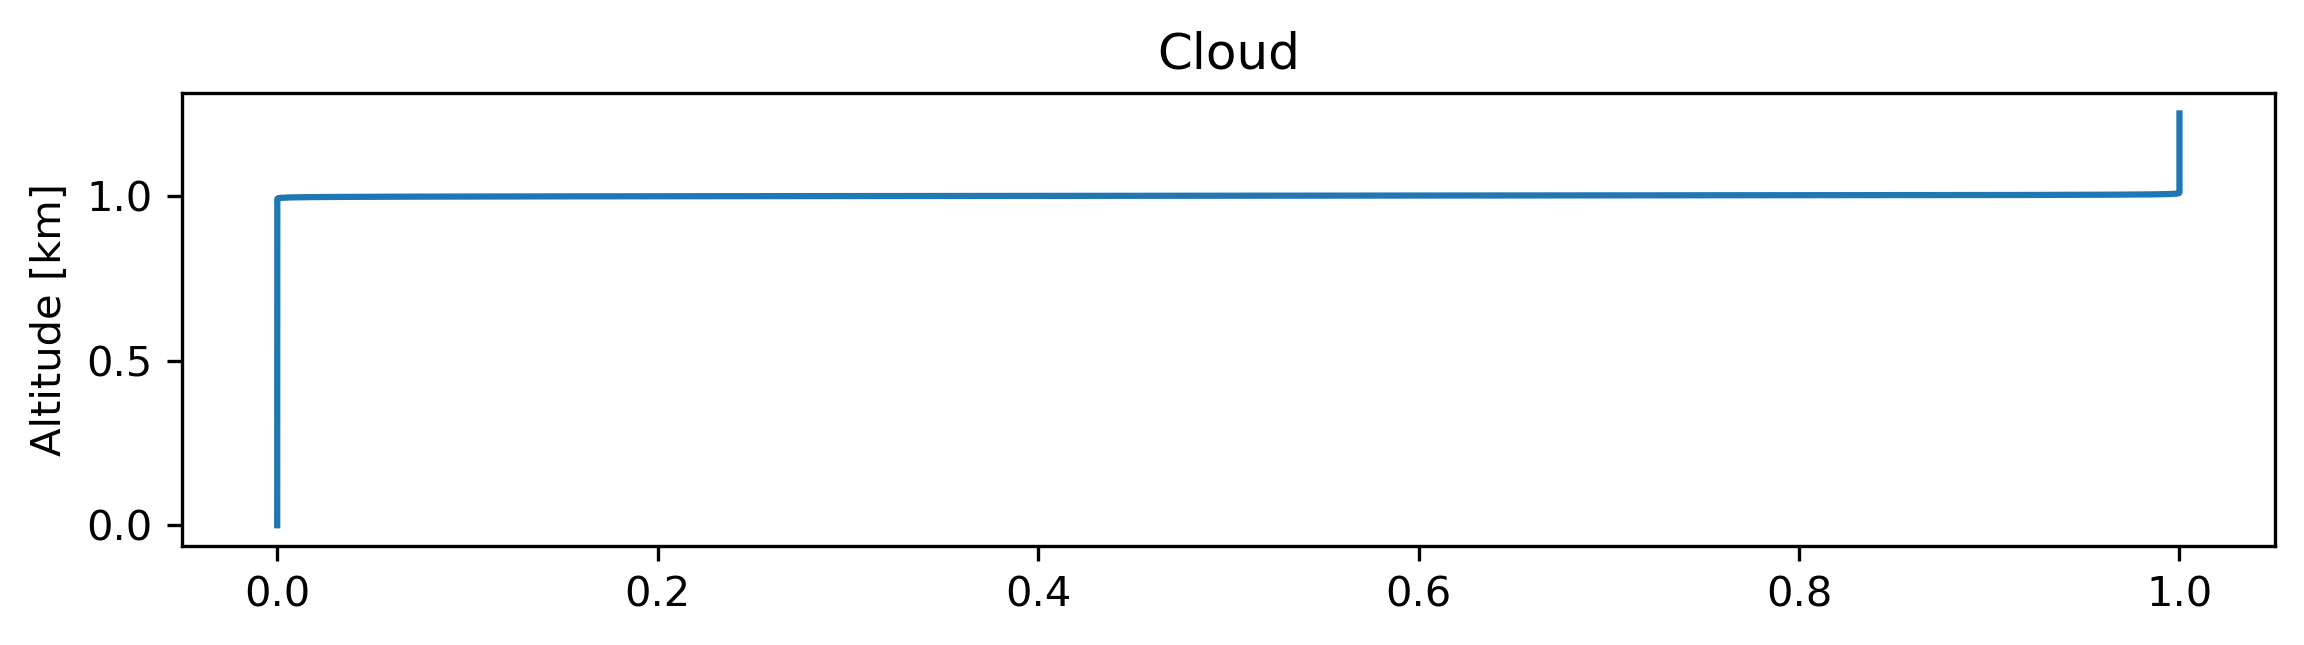

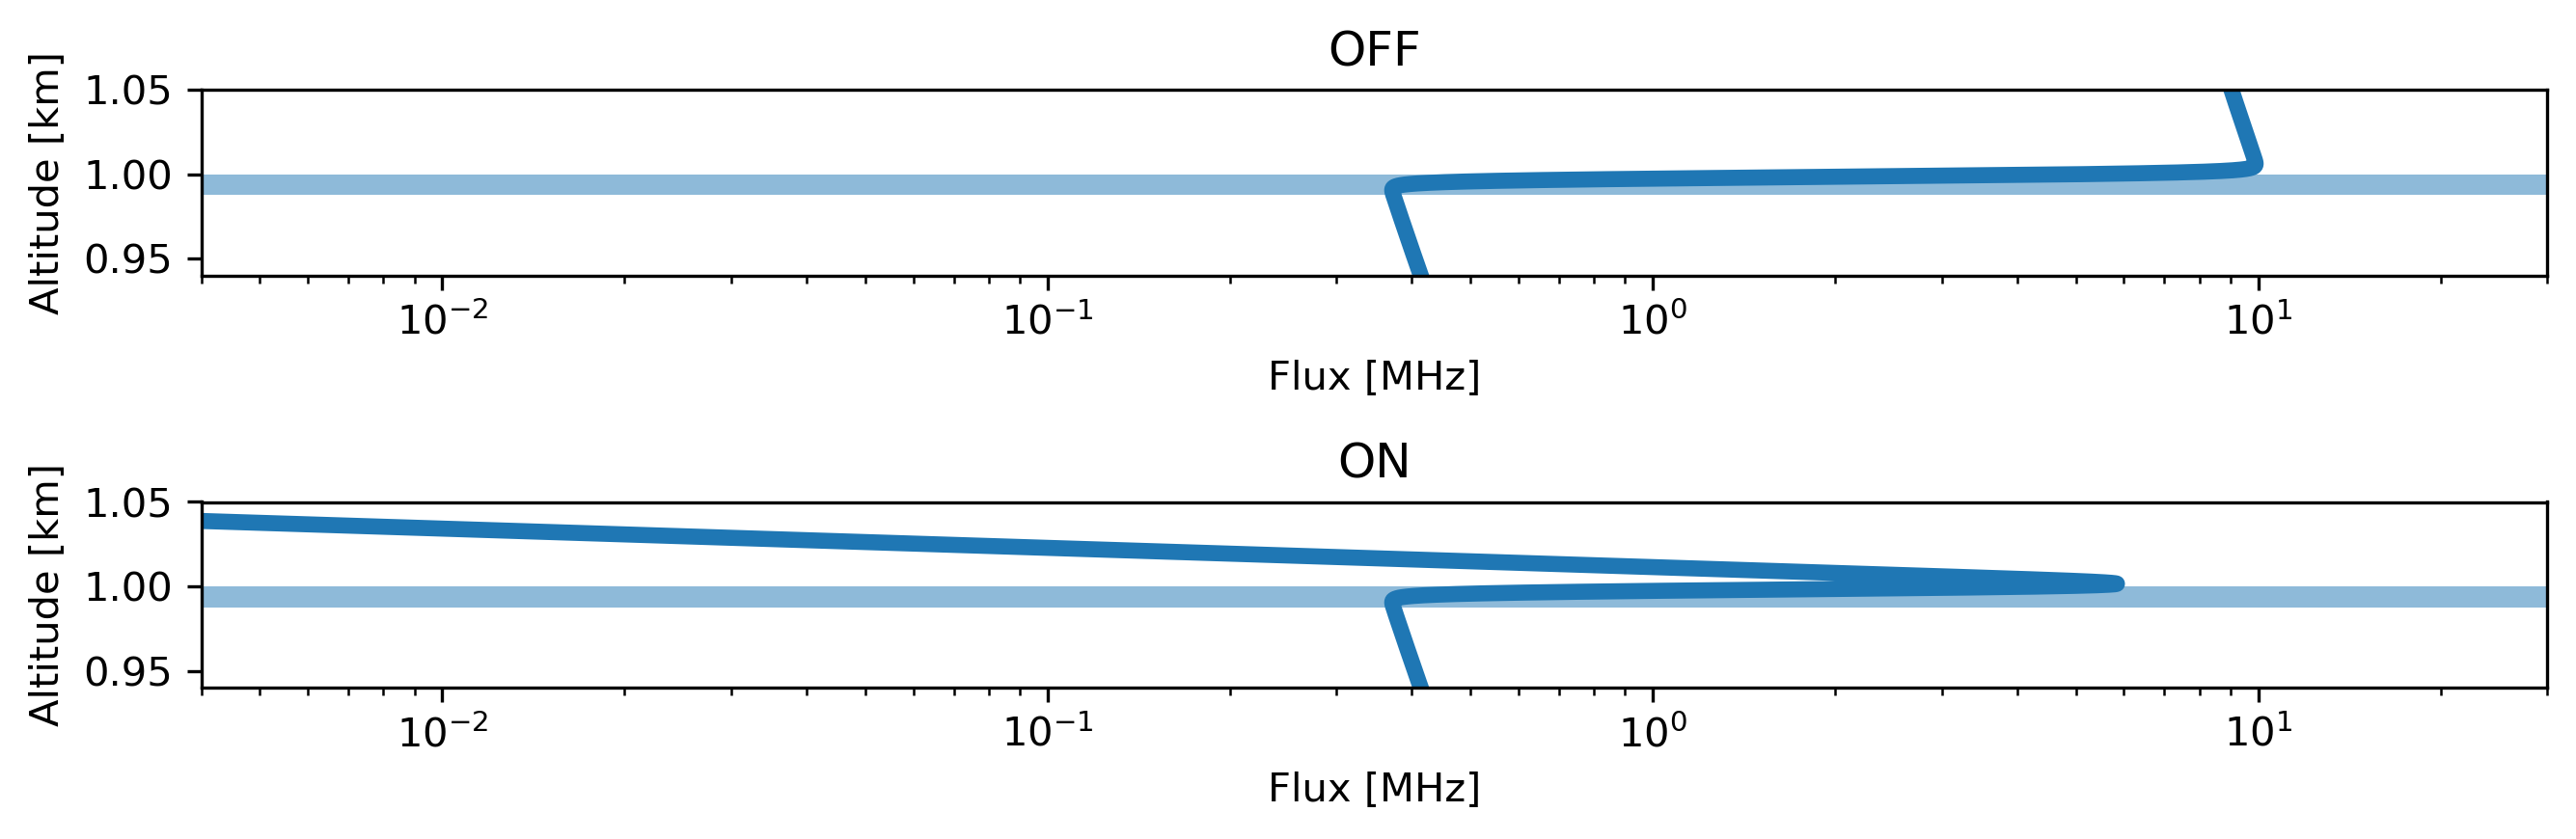

In [208]:
photon_rate_off, N_com_off, cloud = gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S_off, beta_aer_off, alpha_mol, beta_mol, dR, N_L, A, eta*T_BS_HG, G, N_B, dt_TCSPC)
photon_rate_on, N_com_on, _ = gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S_on, beta_aer_on, alpha_mol, beta_mol, dR, N_L, A, eta*T_BS_HG, G, N_B, dt_TCSPC)

# # Hack the signal to make it more in reasonable flux ranges...
# atten = 200
# photon_rate_off /= atten
# N_com_off /= atten
# photon_rate_on /= atten
# N_com_on /= atten

# Check cloud + mol signal

fig = plt.figure(figsize=(9, 2), dpi=300)
ax = fig.add_subplot(111)
ax.plot(cloud, alt/1e3)
ax.set_ylabel('Altitude [km]')
ax.set_title('Cloud')
plt.show()

fig = plt.figure(figsize=(9, 3), dpi=300)
ax1 = fig.add_subplot(211)
ax1.plot(photon_rate_off/1e6, R/1e3, '-', linewidth=4)
ax1.set_title('OFF')
ax1.set_ylabel('Altitude [km]')
ax1.set_xlabel('Flux [MHz]')
# ax1.set_title('Cloud Edge Backscatter')
ax1.set_xlim([4e-3, 3e1])
ax1.set_ylim([0.94, 1.05])
ax1.fill_between([4e-3, 3e3], 0.9875, 1.00, alpha=0.5)
ax1.set_xscale('log')
ax1 = fig.add_subplot(212)
ax1.plot(photon_rate_on/1e6, R/1e3, '-', linewidth=4)
ax1.set_title('ON')
ax1.set_ylabel('Altitude [km]')
ax1.set_xlabel('Flux [MHz]')
# ax1.set_title('Cloud Edge Backscatter')
ax1.set_xlim([4e-3, 3e1])
ax1.set_ylim([0.94, 1.05])
ax1.fill_between([4e-3, 3e3], 0.9875, 1.00, alpha=0.5)
ax1.set_xscale('log')
plt.tight_layout()
plt.show()

Offline Flux at Cloud Base: 7.366 MHz
Online Flux at Cloud Base: 4.494 MHz


C:\Users\Grant\AppData\Local\Temp\ipykernel_5796\3331032403.py:10: RuntimeWarning: invalid value encountered in divide
  true_conc = 1/2/xsec/dR*np.diff(np.log((phi_off)/(phi_on)))


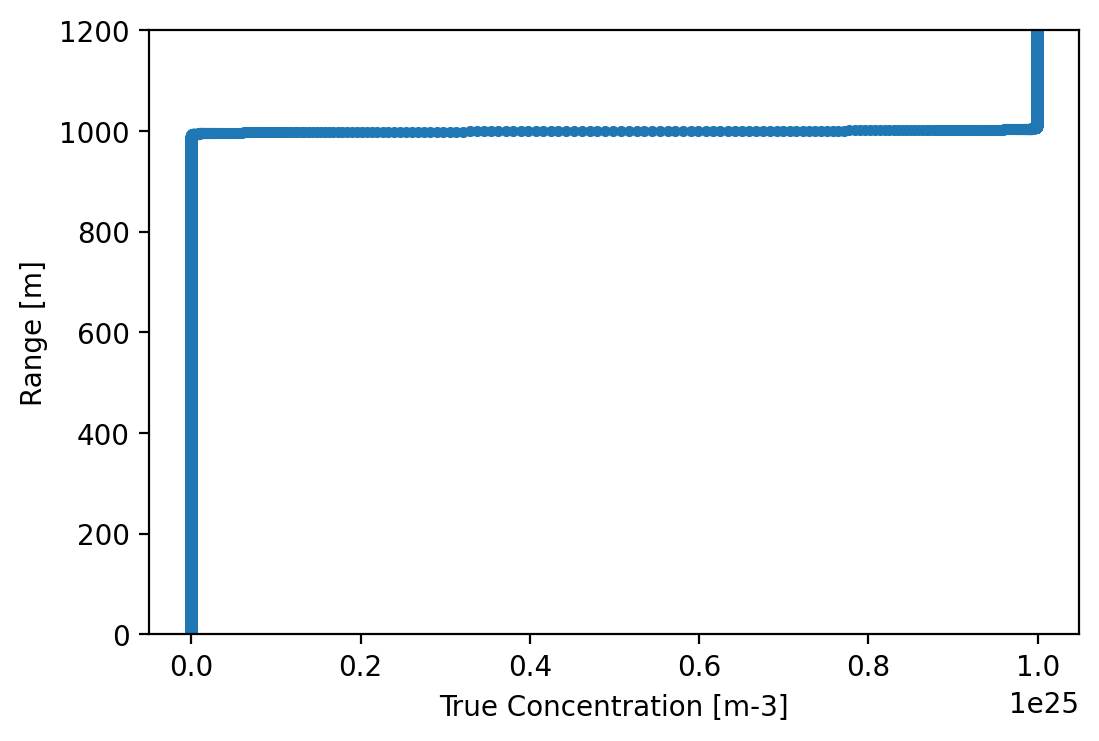

In [203]:
# tau_aim = 1  # Aiming for optical depth value of 1 
phi_off = photon_rate_off  # [Hz] offline flux
phi_on = photon_rate_on  # [Hz] online flux
# phi_on = phi_off_amp / np.e**(2*tau_aim)
# print('Ideal Optical Depth: {}'.format(tau_aim))
print('Offline Flux at Cloud Base: {:.3f} MHz'.format(np.max(phi_off)/1e6))
print('Online Flux at Cloud Base: {:.3f} MHz'.format(np.max(phi_on)/1e6))

dR = np.diff(R)[0]  # [m]
true_conc = 1/2/xsec/dR*np.diff(np.log((phi_off)/(phi_on)))

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(true_conc, (R[:-1]+dR/2), '.')
ax.set_xlabel('True Concentration [m-3]')
ax.set_ylabel('Range [m]')
ax.set_ylim([0, 1200])
# ax.set_xlim([-100, 1.5e20])
plt.show()

In [218]:
Nshot = 14700 * 1
print('{} shots'.format(Nshot))
print('{:.4f} sec of simulated data'.format(Nshot/f_L))

shift_bot = 950  # [m] what altitude to shift simulation axis to not plot anything below
shift_top = 1050  # [m] top as well
idx_bot_shift = np.argmin(np.abs(alt-shift_bot))
idx_top_shift = np.argmin(np.abs(alt-shift_top))
photon_rate_off_shift = photon_rate_off[idx_bot_shift:idx_top_shift]
photon_rate_on_shift = photon_rate_on[idx_bot_shift:idx_top_shift]

sim_time = alt / c * 2  # [s]
sim_time[0] = 0
sim_time = sim_time[idx_bot_shift:idx_top_shift+1]
sim_time -= np.min(sim_time)

t_res = dalt / c * 2  # [s]

14700 shots
1.0000 sec of simulated data


In [247]:
##### GENERATE SIMULATED DATA #####

# simulation resolution settings
if type(Nshot) != int:
    Nshot = int(Nshot)  # number of laser shots

wrap_deadtime = False

# generate photon counts

# lists of photon arrivals per laser shot
sync_idx = np.arange(Nshot)  # sync value
det_sync_idx = []
phot_sync_idx = []
det_events = []
phot_events = []

photon_rate_lst = [photon_rate_off_shift, photon_rate_on_shift]

for i in range(2):
    start = time.time()
    det_sync_idx_line = []
    phot_sync_idx_line = []
    det_events_line = []
    phot_events_line = []
    
    photon_rate = photon_rate_lst[i]  # [Hz]
    
    t_det_last = -100.0  # last photon detection event
    for n in range(Nshot):    
        # simulate a laser shot
        ptime, ctime = sim.photon_count_generator(sim_time, photon_rate, tau_d_flt=tD, last_photon_flt=t_det_last)
        if wrap_deadtime:
            if len(ctime) > 0:
                t_det_last = ctime[-1]
            t_det_last -= t_sim_bins[-1]

        ctime /= t_res  # convert from s to clock counts since sync event
        ptime /= t_res  # convert from s to clock counts since sync event

        for i in range(len(ctime)):
            det_events_line.append(ctime[i])  # detection time tags
            det_sync_idx_line.append(n)
        for i in range(len(ptime)):
            phot_events_line.append(ptime[i])  # photon time tags
            phot_sync_idx_line.append(n)

    print('Time elapsed: {} s'.format(time.time()-start))
    
    det_events.append(det_events_line)
    det_sync_idx.append(det_sync_idx_line)
    phot_events.append(phot_events_line)
    phot_sync_idx.append(phot_sync_idx_line)   

Time elapsed: 17.51240372657776 s
Time elapsed: 4.6360509395599365 s


In [248]:
det_events_off = np.array(det_events[0])
det_sync_idx_off = np.array(det_sync_idx[0])
phot_events_off = np.array(phot_events[0])
phot_sync_idx_off = np.array(phot_sync_idx[0])
det_events_on = np.array(det_events[1])
det_sync_idx_on = np.array(det_sync_idx[1])
phot_events_on = np.array(phot_events[1])
phot_sync_idx_on = np.array(phot_sync_idx[1])

In [249]:
avg_range = 250
plot_bins = sim_time[::avg_range]  # [s]

n_det_off, bins = np.histogram(det_events_off*t_res, bins=plot_bins)
dt = np.diff(bins)[0]
det_flux_off = n_det_off/dt/Nshot

n_phot_off, _ = np.histogram(phot_events_off*t_res, bins=plot_bins)
phot_flux_off = n_phot_off/dt/Nshot

n_det_on, _ = np.histogram(det_events_on*t_res, bins=plot_bins)
det_flux_on = n_det_on/dt/Nshot

n_phot_on, _ = np.histogram(phot_events_on*t_res, bins=plot_bins)
phot_flux_on = n_phot_on/dt/Nshot

print('Plotting range resolution: {:.2f} m'.format(dt*c/2))

Plotting range resolution: 9.37 m


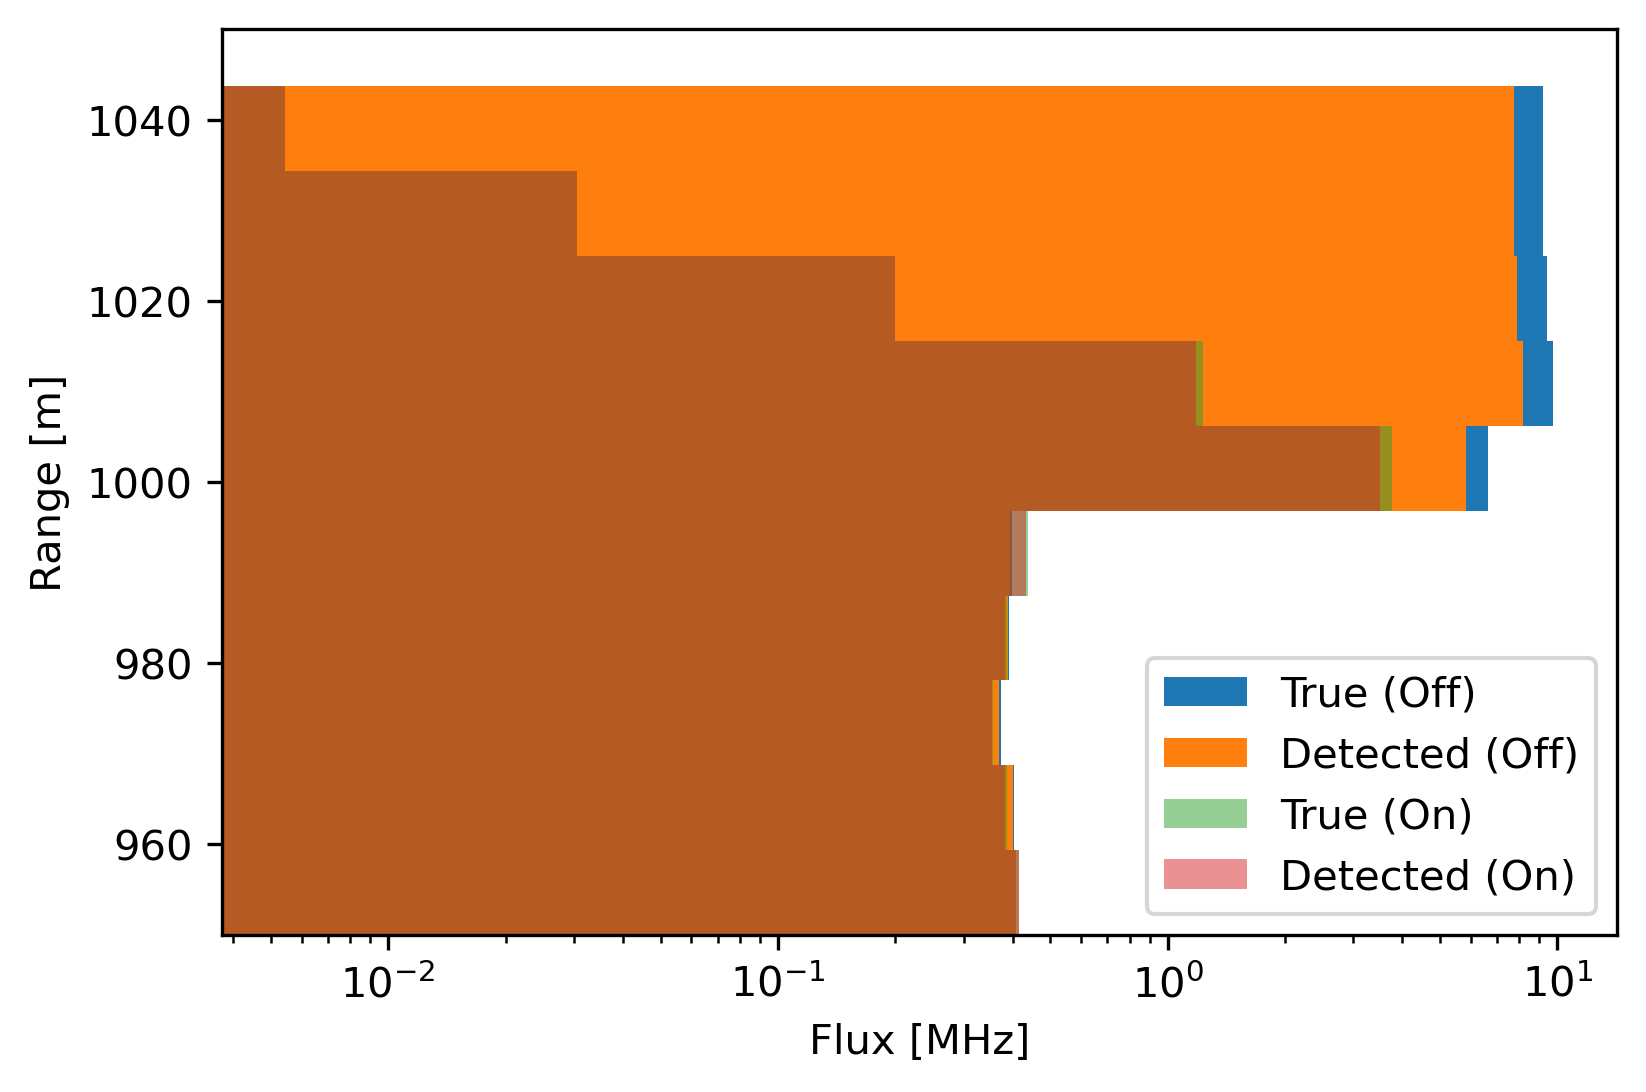

In [250]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, phot_flux_off/1e6, height=dt*c/2, label='True (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, det_flux_off/1e6, height=dt*c/2, label='Detected (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, phot_flux_on/1e6, height=dt*c/2, alpha=0.5, label='True (On)')
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, det_flux_on/1e6, height=dt*c/2, alpha=0.5, label='Detected (On)')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_ylim([shift_bot, shift_top])
ax.set_xscale('log')
plt.legend()
plt.show()

In [251]:
dR_avg = dt * c / 2  # [m]
meas_conc = 1/2/xsec/dR_avg*np.diff(np.log(det_flux_off/det_flux_on))  # [m-3]
muller_conc = 1/2/xsec/dR_avg*np.diff(np.log((det_flux_off/(1-tD*det_flux_off))/(det_flux_on/(1-tD*det_flux_on))))  # [m-3]
true_conc = 1/2/xsec/dR_avg*np.diff(np.log((phi_off[idx_bot_shift:idx_top_shift][::avg_range])/(phi_on[idx_bot_shift:idx_top_shift][::avg_range])))

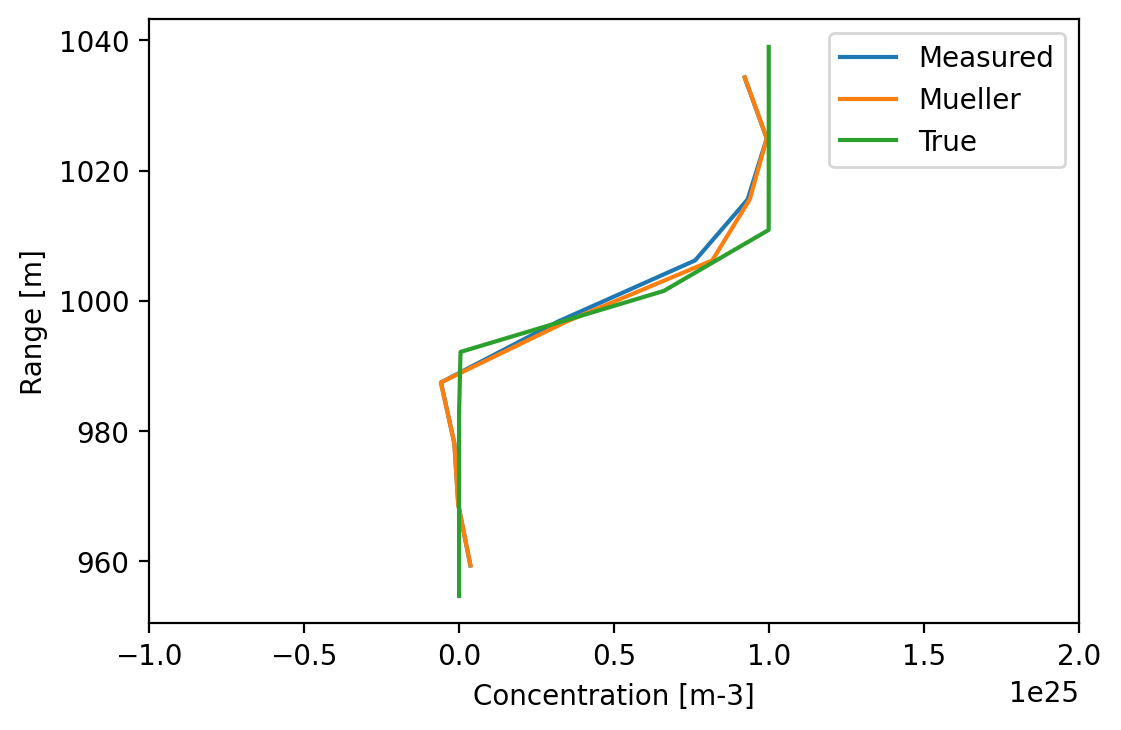

In [252]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(meas_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Measured')
ax.plot(muller_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Mueller')
ax.plot(true_conc, (plot_bins[:-1]+dt/2)*c/2+shift_bot, label='True')
ax.set_xlabel('Concentration [m-3]')
ax.set_ylabel('Range [m]')
ax.set_xlim([-1e25, 2e25])
# ax.set_ylim([980, 1020])
# ax.set_xscale('log')
plt.legend()
plt.show()